In [1]:
!nvidia-smi

Sun Nov 20 18:58:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!mkdir ~/.kaggle/ && mv kaggle.json ~/.kaggle/

In [21]:
!kaggle datasets download -d jangsienicajzkowy/afo-aerial-dataset-of-floating-objects
!unzip afo-aerial-dataset-of-floating-objects.zip && rm afo-aerial-dataset-of-floating-objects.zip

In [22]:
%cd "./drive/MyDrive"
!cp "afo_clean_datset.csv" "../../"
%cd "../../"

In [6]:
! pip -q install pybboxes

In [1]:
import os
import gc
import cv2
import time
import shutil
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from tqdm import tqdm
import pybboxes as pbx
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

class cfg:
  DEBUG = False
  path = './data/PART_1/PART_1/'
  path2category1 = './data/PART_1/PART_1/1category'
  path2images = './data/PART_1/PART_1/images/'
  path2drive = './drive/MyDrive'
  log_dir = './logs'
  model_dir = './models'
  data_dir = './data/'
  n_epochs = 10
  eta_min = 1e-6
  use_amp = True
  kernel_type = 'fastercnn_resnet50'

os.makedirs(cfg.data_dir, exist_ok=True)
os.makedirs(cfg.log_dir, exist_ok=True)
os.makedirs(cfg.model_dir, exist_ok=True)

if os.path.exists("./PART_1") or os.path.exists("./PART_2") or os.path.exists("./PART_3"):
  shutil.move("./PART_1", "./data/PART_1")
  shutil.move("./PART_2", "./data/PART_2")
  shutil.move("./PART_3", "./data/PART_3")

In [2]:
data = os.listdir(os.path.join(cfg.path, 'images'))
df = pd.DataFrame({
    "images": data
})
df['dir_path'] = cfg.path
df['path2img'] = df['dir_path'] + '/' + df['images']

list_of_imgs = sorted(df['images'].apply(lambda x: x[:-4]).tolist())

# `1category` contains bounding box coordinates for all images
category_one_data = os.listdir(os.path.join(cfg.path, '1category'))
category_one_df = pd.DataFrame({
    "1category": sorted(category_one_data)
})

# `images` in `part1` only contain `1/3` of all images
# the rest of the 2/3 of images are in `part2` and `part3`
# so we need to filter out only the bounding box coordinates for images in `part1` from `1category`
list_of_1category_labels = category_one_df['1category'].apply(lambda x: x[:-4]).tolist()
filtered_1category_labels = sorted(list(set(list_of_1category_labels).intersection(list_of_imgs)))

data = filtered_1category_labels.copy()
filtered_1category_labels_df = pd.DataFrame({
    '1category': data
})
filtered_1category_labels_df['1category'] = filtered_1category_labels_df['1category'].apply(lambda x: x+'.txt')

# https://stackoverflow.com/questions/36133716/how-to-skip-reading-empty-files-with-panda-in-python
def is_non_zero_file(fpath):  
    """check if file is empty"""
    return os.path.isfile(fpath) and os.path.getsize(fpath) > 0

data = sorted(os.listdir(cfg.path2category1))
category1length = len(os.listdir(cfg.path2category1))
target_cols = ['x', 'y', 'w', 'h']
tmp_arr = []
filename_arr = []

for i in tqdm(range(category1length), total=category1length):
    file = data[i]
    filename_arr.append(file)
    filepath = os.path.join(cfg.path2category1, file)
    if not is_non_zero_file(filepath):
        tmp_arr.append('[]')
        continue
    else:
        tmp_df = pd.read_csv(os.path.join(cfg.path2category1, file), sep=" ", header=None).drop([0], axis=1).rename(columns={1: "x", 2: "y", 3: "w", 4: "h"})
        bbox_targs = tmp_df[target_cols].values.tolist()
        tmp_arr.append(bbox_targs)

bbox_df_category1 = pd.DataFrame({
    'filename': filename_arr,
    'bbox': tmp_arr
})
bbox_df_category1.head()

# files that contain bounding box coordinates for images only in part1
x = filtered_1category_labels_df['1category'].tolist()

bbox_filtered_df_category1 = bbox_df_category1[bbox_df_category1['filename'].isin(x)]

# filter out the rows where there are no bounding box coordinates
# filter out images where there are no bounding boxes
bbox_filtered_df_category1 = bbox_filtered_df_category1[bbox_filtered_df_category1['bbox'] != '[]'].reset_index(drop=True)

# append .jpg to end of img_file
bbox_filtered_df_category1['img_file'] = bbox_filtered_df_category1['filename'].apply(lambda x: x[:-4]+'.jpg')


100%|██████████| 3641/3641 [00:10<00:00, 334.45it/s]


In [3]:
folds = bbox_filtered_df_category1.copy()
kf = KFold(5)
folds['fold'] = -1
for fold, (train_idx, valid_idx) in enumerate(kf.split(folds, folds)):
    folds.loc[valid_idx, 'fold'] = fold
    
# save dataset
folds.to_csv(f'{cfg.path2drive}/afo_clean_dataset.csv', index=False)
folds.tail()

,filename,bbox,img_file,fold
970,d_454.txt,"[[0.3260416666666667, 0.6722222222222223, 0.03...",d_454.jpg,4
971,d_455.txt,"[[0.3244791666666666, 0.6712962962962963, 0.03...",d_455.jpg,4
972,dv_0.txt,"[[0.6442708333333333, 0.6625, 0.01223958333333...",dv_0.jpg,4
973,dv_1199.txt,"[[0.38203125, 0.6467592592592593, 0.0080729166...",dv_1199.jpg,4
974,dv_1409.txt,"[[0.378125, 0.5643518518518519, 0.01171875, 0....",dv_1409.jpg,4


In [4]:
class AFODataset(Dataset):
  
    def __init__(self, df, transforms=None):
        super().__init__()

        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index: int):
        img_file = self.df['img_file'].values[index] 
        bboxes = self.df['bbox'].values[index]
        records = len(bboxes)
        
        image = cv2.imread(f'{cfg.path2images}{img_file}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        converted_bboxes = []
        for bbox in bboxes:
            W, H = image.shape[1], image.shape[0]  
            yolo_bbox = tuple(bbox)
            x,y,w,h = pbx.convert_bbox(yolo_bbox, from_type="yolo", to_type="voc", image_size=(W, H))
            new_bboxes = [x,y,w,h]
            converted_bboxes.append(new_bboxes)

        # there is only one class
        labels = torch.ones((records,), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records,), dtype=torch.int64)

        target = {}
        target['boxes'] = torch.tensor(converted_bboxes)
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return torch.tensor(image), target, img_file

In [5]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Resize(240, 320, p=1.0),
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [6]:
show_dataset = AFODataset(folds, get_train_transform())
image, target, img_file = show_dataset[0]

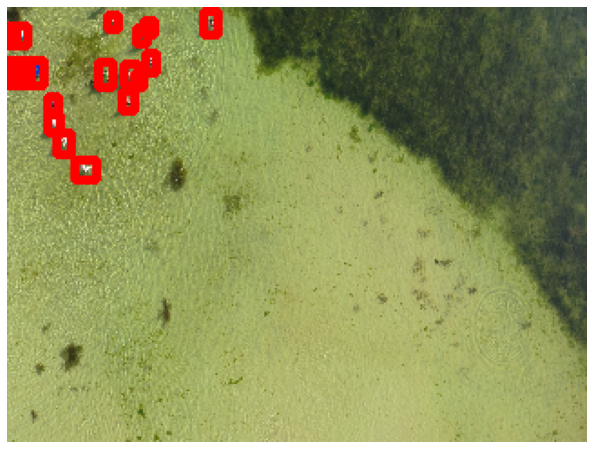

In [7]:
image = image.permute(1,2,0).cpu().numpy()
bbox = target['boxes'].cpu().numpy().astype(np.int32)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in bbox:
    cv2.rectangle(image,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)

ax.set_axis_off()
ax.imshow(image)

In [8]:
def train_fn(model, loader_train, optimizer, scaler, device):
  model.train()

  train_loss = []
  bar = tqdm(loader_train)
  for images, targets, image_ids in bar:
      optimizer.zero_grad()
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
      
      with amp.autocast():
          loss_dict = model(images, targets)
          loss = sum(loss for loss in loss_dict.values())

      train_loss.append(loss.item())
      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()
      
      bar.set_description(f'smth:{np.mean(train_loss[-30:]):.4f}')
  return np.mean(train_loss)

In [9]:
def run(fold):
  def collate_fn(batch):
    return tuple(zip(*batch))
  
  log_file = os.path.join(cfg.log_dir, f'{cfg.kernel_type}.txt')
  model_file = os.path.join(cfg.model_dir, f'{cfg.kernel_type}_fold{fold}_best.pth')

  train_ds = folds[folds['fold'] != fold].reset_index(drop=True)
  # valid_ds = folds[folds['fold'] == fold].reset_index(drop=True)

  train_dataset = AFODataset(train_ds, transforms=get_train_transform())
  # valid_dataset = AFODataset(valid_ds, transforms=get_valid_transform())

  train_data_loader = DataLoader(
      train_dataset,
      batch_size=8,
      shuffle=False,
      num_workers=4,
      collate_fn=collate_fn
  )

  # valid_data_loader = DataLoader(
  #     valid_dataset,
  #     batch_size=8,
  #     shuffle=False,
  #     num_workers=4,
  #     collate_fn=collate_fn
  # )

  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  # load a model; pre-trained on COCO
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  num_classes = 2  # 1 class (wheat) + background
  # get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  params = [p for p in model.parameters() if p.requires_grad]
  optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
  scheduler_cosine = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, cfg.n_epochs, eta_min=cfg.eta_min)
  scaler = torch.cuda.amp.GradScaler() if cfg.use_amp else None
  model = model.to(device)

  metric_best = np.inf
  loss_min = np.inf

  for epoch in range(1, cfg.n_epochs+1):
    scheduler_cosine.step(epoch-1)

    train_loss = train_fn(model, train_data_loader, optimizer, scaler, device)
    metric = train_loss
  
    content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}.'
    print(content)
    with open(log_file, 'a') as appender:
      appender.write(content + '\n')

    if metric < metric_best:
      print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
      torch.save(model.state_dict(), model_file)
      metric_best = metric
    
    # Save Last
    if not cfg.DEBUG:
        torch.save(
            {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scaler_state_dict': scaler.state_dict() if scaler else None,
                'loss_minimum': metric_best,
            },
            model_file.replace('_best', '_last')
        )

    # del model
    torch.cuda.empty_cache()
    gc.collect()

In [10]:
run(0)

smth:1.2036: 100%|██████████| 98/98 [02:11<00:00,  1.34s/it]


Sun Nov 20 20:10:21 2022 Fold 0, Epoch 1, lr: 0.0050000, train loss: 1.11438.
metric_best (inf --> 1.114383). Saving model ...


smth:1.1296: 100%|██████████| 98/98 [02:11<00:00,  1.34s/it]


Sun Nov 20 20:12:34 2022 Fold 0, Epoch 2, lr: 0.0048777, train loss: 1.01212.
metric_best (1.114383 --> 1.012117). Saving model ...


smth:1.0787: 100%|██████████| 98/98 [02:11<00:00,  1.34s/it]


Sun Nov 20 20:14:47 2022 Fold 0, Epoch 3, lr: 0.0045226, train loss: 0.97889.
metric_best (1.012117 --> 0.978886). Saving model ...


smth:1.0399: 100%|██████████| 98/98 [02:12<00:00,  1.35s/it]


Sun Nov 20 20:17:01 2022 Fold 0, Epoch 4, lr: 0.0039697, train loss: 0.93334.
metric_best (0.978886 --> 0.933345). Saving model ...


smth:1.0095: 100%|██████████| 98/98 [02:11<00:00,  1.34s/it]


Sun Nov 20 20:19:14 2022 Fold 0, Epoch 5, lr: 0.0032729, train loss: 0.91336.
metric_best (0.933345 --> 0.913356). Saving model ...


smth:0.9823: 100%|██████████| 98/98 [02:10<00:00,  1.34s/it]


Sun Nov 20 20:21:26 2022 Fold 0, Epoch 6, lr: 0.0025005, train loss: 0.89269.
metric_best (0.913356 --> 0.892691). Saving model ...


smth:0.9559: 100%|██████████| 98/98 [02:11<00:00,  1.35s/it]


Sun Nov 20 20:23:40 2022 Fold 0, Epoch 7, lr: 0.0017281, train loss: 0.87948.
metric_best (0.892691 --> 0.879478). Saving model ...


smth:0.9322: 100%|██████████| 98/98 [02:11<00:00,  1.35s/it]


Sun Nov 20 20:25:54 2022 Fold 0, Epoch 8, lr: 0.0010313, train loss: 0.86308.
metric_best (0.879478 --> 0.863077). Saving model ...


smth:0.9116: 100%|██████████| 98/98 [02:12<00:00,  1.35s/it]


Sun Nov 20 20:28:07 2022 Fold 0, Epoch 9, lr: 0.0004784, train loss: 0.84655.
metric_best (0.863077 --> 0.846549). Saving model ...


smth:0.8962: 100%|██████████| 98/98 [02:11<00:00,  1.35s/it]


Sun Nov 20 20:30:22 2022 Fold 0, Epoch 10, lr: 0.0001233, train loss: 0.83303.
metric_best (0.846549 --> 0.833025). Saving model ...


In [19]:
def eval(fold):
  def collate_fn(batch):
    return tuple(zip(*batch))

  valid_ds = folds[folds['fold'] == fold].reset_index(drop=True)
  valid_dataset = AFODataset(valid_ds, transforms=get_valid_transform())
  valid_data_loader = DataLoader(
      valid_dataset,
      batch_size=8,
      shuffle=False,
      num_workers=4,
      collate_fn=collate_fn
  )

  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  cpu_device = torch.device("cpu")
  # load a model; pre-trained on COCO
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  num_classes = 2  # 1 class (wheat) + background
  # get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  model.load_state_dict(torch.load(f'./{cfg.model_dir}/fastercnn_resnet50_fold0_best.pth'))
  model.to(device)
  model.eval()

  images, targets, image_ids = next(iter(valid_data_loader))

  images = list(img.to(device) for img in images)
  targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

  sample = images[3].permute(1,2,0).cpu().numpy() 
  target_boxes = targets[3]['boxes'].cpu().numpy().astype(np.int32)

  fig, ax = plt.subplots(1, 2, figsize=(32, 16))

  for box in target_boxes:
      cv2.rectangle(sample,
                    (box[0], box[1]),
                    (box[2], box[3]),
                    (220, 0, 0), 3)
    
  ax[0].set_title("Target boxes")
  ax[0].set_axis_off()
  ax[0].imshow(sample)

  outputs = model(images)
  outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

  sample = images[3].permute(1,2,0).cpu().numpy()
  pred_boxes = outputs[3]['boxes'].cpu().detach().numpy().astype(np.int32)

  for box in pred_boxes:
      cv2.rectangle(sample,
                    (box[0], box[1]),
                    (box[2], box[3]),
                    (220, 0, 0), 3)
  
  ax[1].set_title("Prediction boxes")
  ax[1].set_axis_off()
  ax[1].imshow(sample)

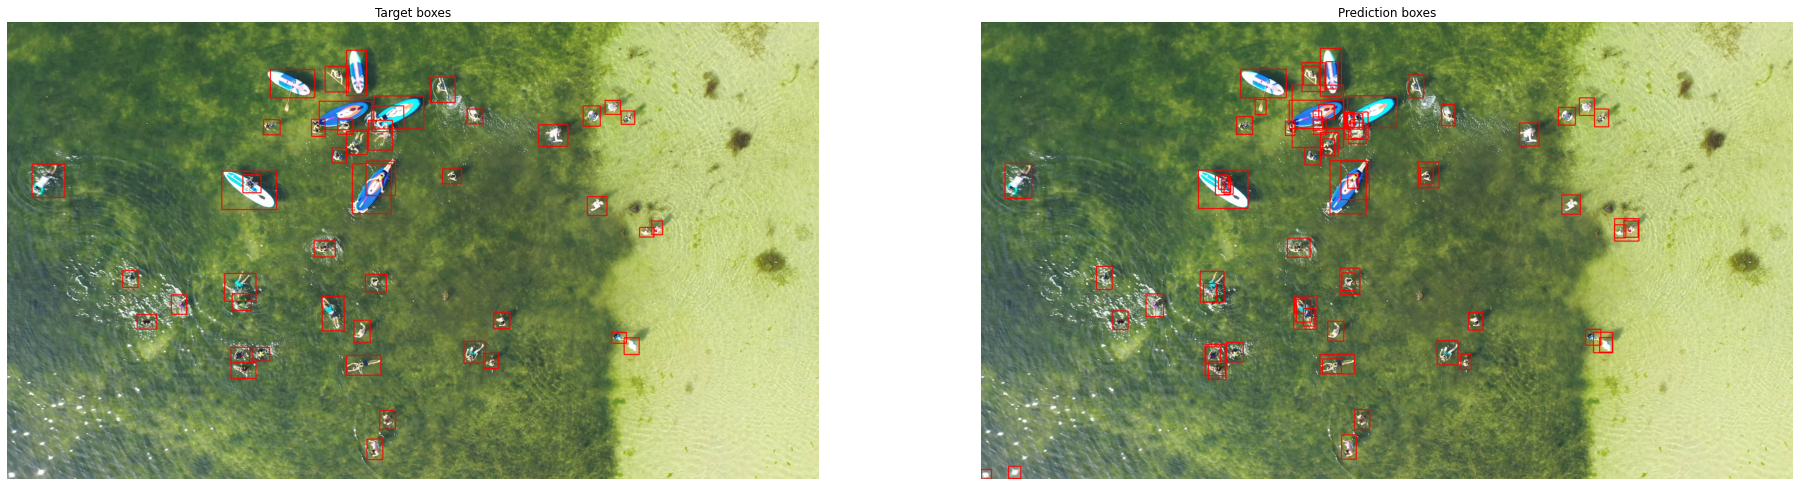

In [20]:
eval(0)